C:\Users\inho9\AppData\Local\Temp\ipykernel_24572\3645886104.py:150: UserWarning: CRS가 투영 좌표(미터)가 아닐 수 있습니다. 푸리에 주파수/길이 해석이 왜곡될 수 있으니 EPSG:5186 등으로 재투영을 권장합니다.
  warnings.warn(


{'shape': (180, 204), 'dx_m': 114.7401892156888, 'dy_m': 114.74018944444445, 'W_m': 20538.493869608294, 'H_m': 23292.258457222226, 'alpha': 0.9, 'Kc': 81, 'Lc': 91, 'crs': 'EPSG:3857', 'is_projected_meter': False}


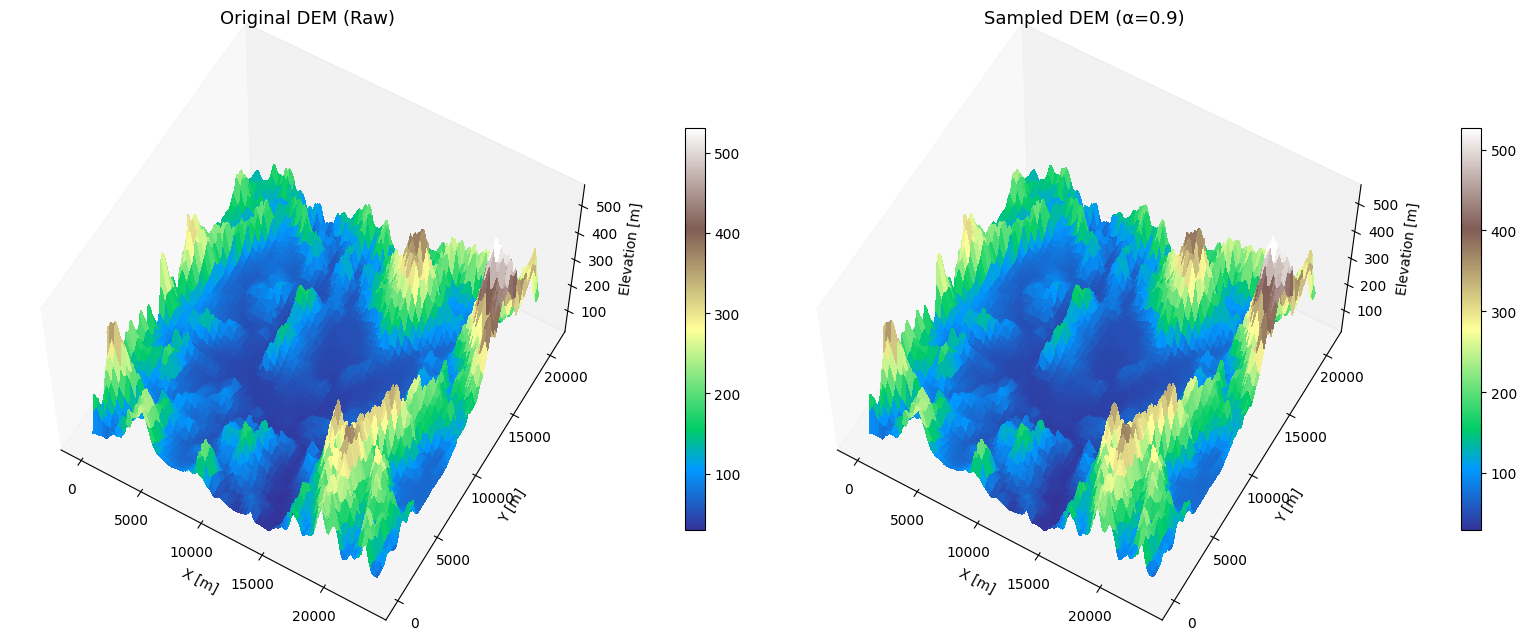

In [10]:
# dem_spectral.py
import warnings
import json
import numpy as np
import rasterio as rio
from scipy.fft import dctn
from scipy.ndimage import distance_transform_edt

def _fillnan_nearest(arr: np.ndarray, nodata=None) -> np.ndarray:
    """
    NaN 혹은 nodata를 최근접값으로 채움(Nearest-neighbor).
    """
    Z = arr.astype(float).copy()
    if nodata is not None:
        Z[Z == nodata] = np.nan

    mask = np.isnan(Z)
    if not np.any(mask):
        return Z

    # 최근접 채우기
    # distance_transform_edt는 mask=False 위치에서의 인덱스를 반환하도록 함
    idx = np.array(np.nonzero(~mask)).T
    dist, inds = distance_transform_edt(mask, return_indices=True)
    Z_filled = Z[tuple(inds)]
    return Z_filled

def build_dem_spectral_model(
    tif_path: str,
    alpha: float = 0.5,
    fill_method: str = "nearest",
    max_modes: tuple[int | None, int | None] = (None, None),
    save_npz: str | None = None,
    return_reconstruction: bool = False,
):
    """
    GeoTIFF DEM을 입력으로 받아 2D-DCT(II) 기반 스펙트럴 파라미터를 생성.

    Parameters
    ----------
    tif_path : str
        입력 DEM GeoTIFF 경로.
    alpha : float
        저역통과 비율(0~1). 예: 0.5면 약 절반의 저주파만 유지.
        (Kc ≈ alpha * M/2, Lc ≈ alpha * N/2)
    fill_method : {"nearest"}
        결측치 보간 방식. 현재 최근접("nearest")만 제공.
    max_modes : (int|None, int|None)
        (Kc, Lc)를 직접 지정하고 싶을 때 사용. None이면 alpha에서 자동 산출.
    save_npz : str|None
        저장 경로 지정 시, 계수/메타데이터를 .npz로 저장.
    return_reconstruction : bool
        True면 저역통과 후 IDCT로 복원한 90m 격자(Z_hat)를 함께 반환.

    Returns
    -------
    result : dict
        {
          "shape": (M, N),
          "dx_m": float, "dy_m": float,
          "W_m": float, "H_m": float,
          "alpha": float,
          "Kc": int, "Lc": int,
          "crs": str|None,
          "is_projected_meter": bool,
          "transform": tuple,           # Affine 6요소
          "A_lp": np.ndarray,          # 저역통과된 DCT 계수 (M,N)
          "dct_norm": "ortho",
          "bounds_m": (xmin,xmax,ymin,ymax)
          # (선택) "Z_hat": np.ndarray
        }
    """
    # --- 1) GeoTIFF 읽기 ---
    with rio.open(tif_path) as ds:
        Z = ds.read(1)  # 첫 밴드 DEM
        transform = ds.transform
        crs = ds.crs.to_string() if ds.crs else None

        # 픽셀 사이즈(미터 단위 가정; 위경도면 경고)
        dx = abs(transform.a)
        dy = abs(transform.e)
        M, N = Z.shape

        # 물리 크기(한 변 픽셀-1 곱): 표본 경계 간 거리
        W = (M - 1) * dx
        H = (N - 1) * dy

        # 경계 박스(대략)
        xmin = transform.c
        ymax = transform.f
        xmax = xmin + N * transform.a
        ymin = ymax + M * transform.e

        # 좌표계가 투영(미터)인지 점검
        is_projected_meter = False
        if ds.crs:
            try:
                # 간단 휴리스틱: 단위가 metre인 EPSG일 때가 일반적
                is_projected_meter = ds.crs.axis_info and ds.crs.axis_info[0].unit_name.lower() in ("metre", "meter")
            except Exception:
                pass

    # --- 2) 결측치 보간 ---
    nodata = None
    with rio.open(tif_path) as ds:
        nodata = ds.nodata

    if fill_method == "nearest":
        Z_filled = _fillnan_nearest(Z, nodata=nodata)
    else:
        raise NotImplementedError("현재는 fill_method='nearest'만 지원합니다.")

    # --- 3) 2D-DCT(II) ---
    # 정규화(norm='ortho')로 계수 스케일을 안정화
    A = dctn(Z_filled, type=2, norm='ortho')

    # --- 4) 저역통과 마스킹 ---
    if max_modes[0] is not None and max_modes[1] is not None:
        Kc, Lc = max_modes
    else:
        Kc = int(alpha * M / 2)
        Lc = int(alpha * N / 2)

    Kc = max(0, min(Kc, M - 1))
    Lc = max(0, min(Lc, N - 1))

    mask = np.zeros_like(A, dtype=bool)
    mask[:Kc + 1, :Lc + 1] = True
    A_lp = np.where(mask, A, 0.0)

    result = {
        "shape": (M, N),
        "dx_m": dx,
        "dy_m": dy,
        "W_m": W,
        "H_m": H,
        "alpha": float(alpha),
        "Kc": int(Kc),
        "Lc": int(Lc),
        "crs": crs,
        "is_projected_meter": bool(is_projected_meter),
        "transform": (transform.a, transform.b, transform.c, transform.d, transform.e, transform.f),
        "A_lp": A_lp,
        "dct_norm": "ortho",
        "bounds_m": (xmin, xmax, ymin, ymax),
    }

    # 경고: 위경도 좌표계(degree)일 가능성
    if not is_projected_meter:
        warnings.warn(
            "CRS가 투영 좌표(미터)가 아닐 수 있습니다. "
            "푸리에 주파수/길이 해석이 왜곡될 수 있으니 EPSG:5186 등으로 재투영을 권장합니다.",
            UserWarning
        )

    # --- (선택) 저역통과 복원 ---
    if return_reconstruction:
        # IDCT는 필요 시: from scipy.fft import idctn  후 사용
        from scipy.fft import idctn
        Z_hat = idctn(A_lp, type=2, norm='ortho')
        result["Z_hat"] = Z_hat

    # --- 저장(.npz) ---
    if save_npz is not None:
        # 큰 배열 저장: A_lp만 저장하고 메타는 JSON 문자열로 함께 저장
        meta = result.copy()
        A_lp_to_save = meta.pop("A_lp")
        # Z_hat은 용량이 클 수 있어 있으면 저장, 없으면 생략
        Z_hat_to_save = meta.pop("Z_hat", None)

        np.savez_compressed(
            save_npz,
            A_lp=A_lp_to_save,
            Z_hat=Z_hat_to_save if Z_hat_to_save is not None else np.array([]),
            meta=json.dumps(meta, ensure_ascii=False)
        )

    return result

res = build_dem_spectral_model(
    r"C:\Users\inho9\Desktop\dev\GISProject\DATA\Deajeon.tif",
    alpha=0.9,
    fill_method="nearest",
    save_npz="dem_spectral_alpha05.npz",
    return_reconstruction=True
)

print({
    "shape": res["shape"],
    "dx_m": res["dx_m"], "dy_m": res["dy_m"],
    "W_m": res["W_m"], "H_m": res["H_m"],
    "alpha": res["alpha"], "Kc": res["Kc"], "Lc": res["Lc"],
    "crs": res["crs"], "is_projected_meter": res["is_projected_meter"]
})
# A_lp = res["A_lp"]        # 저역통과 DCT 계수 (정규화 'ortho')
# Z_hat = res.get("Z_hat")  # 복원된 90m 격자 (선택)

# ==========================================
# 3D Visualization: Original vs Sampled DEM
# ==========================================
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (for 3D plot)
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

# 원본 DEM 읽기 (rasterio로 다시 로드)
import rasterio as rio

with rio.open(r"C:\Users\inho9\Desktop\dev\GISProject\DATA\Deajeon.tif") as ds:
    Z_original = ds.read(1).astype(float)
    Z_original[Z_original == ds.nodata] = np.nan
    dx = abs(ds.transform.a)
    dy = abs(ds.transform.e)

# 샘플링된 DEM
Z_sampled = res["Z_hat"]

# 그리드 좌표 (원본 기준)
M, N = Z_original.shape
x = np.arange(0, N) * dx
y = np.arange(0, M) * dy
X, Y = np.meshgrid(x, y)

# 다운샘플링된 DEM이 원본과 동일 크기라면 그대로 사용
# 만약 shape이 다르다면 interpolation을 추가해야 함

fig = plt.figure(figsize=(16, 7))

# ---- (1) 원본 DEM ----
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(
    X, Y, Z_original,
    cmap=cm.terrain, linewidth=0, antialiased=False, rstride=3, cstride=3
)
ax1.set_title("Original DEM (Raw)", fontsize=13)
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")
ax1.set_zlabel("Elevation [m]")
fig.colorbar(surf1, ax=ax1, shrink=0.6, pad=0.1)

# ---- (2) 저역통과 복원 DEM ----
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(
    X, Y, Z_sampled,
    cmap=cm.terrain, linewidth=0, antialiased=False, rstride=3, cstride=3
)
ax2.set_title(f"Sampled DEM (α={res['alpha']})", fontsize=13)
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")
ax2.set_zlabel("Elevation [m]")
fig.colorbar(surf2, ax=ax2, shrink=0.6, pad=0.1)

# ---- 보기 좋게 각도 조정 ----
for ax in [ax1, ax2]:
    ax.view_init(elev=60, azim=-60)
    ax.grid(False)

plt.tight_layout()
plt.show()


In [ ]:
# ================================================
# Final: f(x,y) (DCT) 기반 최단경로 + 3D 시각화
# ================================================
import numpy as np
import heapq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
from matplotlib import cm

# ---------- 1) DCT 연속평가 ----------
def evaluate_dct_continuous(A, xs, ys, W, H, Kc=None, Lc=None):
    """
    A: DCT(II) 계수 (M,N), norm='ortho'
    xs, ys: 평가 1D 좌표 [m]
    W, H: 도메인 크기 [m]
    Kc, Lc: 사용할 최대 모드 인덱스
    return: f(x,y) 샘플 (len(xs), len(ys)) 배열
    """
    M, N = A.shape
    if Kc is None: Kc = M - 1
    if Lc is None: Lc = N - 1
    k = np.arange(Kc + 1)[:, None]            # (Kc+1,1)
    l = np.arange(Lc + 1)[None, :]            # (1,Lc+1)
    cx = np.cos(np.pi * np.outer(xs / W, k)).T  # (Kc+1, len(xs))
    cy = np.cos(np.pi * np.outer(ys / H, l))    # (len(ys), Lc+1)
    Ablk = A[:Kc+1, :Lc+1]
    return cx.T @ Ablk @ cy.T                 # (len(xs), len(ys))

# ---------- 2) 격자 이웃 & 휴리스틱 ----------
def _neighbors(rc, shape, connectivity=8):
    r, c = rc
    M, N = shape
    if connectivity == 4:
        deltas = [(1,0),(-1,0),(0,1),(0,-1)]
    else:
        deltas = [(1,0),(-1,0),(0,1),(0,-1),(1,1),(1,-1),(-1,1),(-1,-1)]
    for dr, dc in deltas:
        nr, nc = r+dr, c+dc
        if 0 <= nr < M and 0 <= nc < N:
            yield (nr, nc)

def _heuristic(a, b, connectivity=8):
    (r1, c1), (r2, c2) = a, b
    dr, dc = abs(r1-r2), abs(c1-c2)
    return (dr+dc) if connectivity==4 else max(dr, dc)

# ---------- 3) f(x,y) 기반 격자 샘플 + A* (unit cost) ----------
def shortest_path_on_f_uniform(
    res: dict,
    start_xy: tuple[float, float],
    goal_xy: tuple[float, float],
    dx: float = 90.0,
    dy: float = 90.0,
    connectivity: int = 8,
    mask_by_threshold: bool = False,
    min_elev: float | None = None,
    max_elev: float | None = None,
):
    """
    res: build_dem_spectral_model() 결과 (A_lp, W_m, H_m, Kc, Lc 포함)
    start_xy, goal_xy: (x,y) [m], 도메인 [0,W]x[0,H] 내부
    dx, dy: 샘플 격자 해상도 [m]
    mask_by_threshold: True면 f(x,y) 값 임계로 통과가능 마스크 구성
    """
    A_lp = res["A_lp"]; W = res["W_m"]; H = res["H_m"]
    Kc = res["Kc"]; Lc = res["Lc"]

    # (1) f(x,y) 샘플링 → 라스터 Z
    xs = np.arange(0.0, W + 1e-9, dx)
    ys = np.arange(0.0, H + 1e-9, dy)
    F = evaluate_dct_continuous(A_lp, xs, ys, W, H, Kc=Kc, Lc=Lc)  # (len(xs), len(ys))
    Z = F.T                                     # (M, N) = (len(ys), len(xs))
    M, N = Z.shape

    # (2) 통과가능 마스크
    walkable = np.ones((M, N), dtype=bool)
    if mask_by_threshold:
        if min_elev is not None: walkable &= (Z >= min_elev)
        if max_elev is not None: walkable &= (Z <= max_elev)
        if not walkable.any():
            raise RuntimeError("임계치로 통과가능 셀이 없습니다.")

    # (3) 좌표↔격자 인덱스
    def xy_to_rc(x, y):
        c = int(round(x / dx))
        r = int(round(y / dy))
        return max(0, min(M-1, r)), max(0, min(N-1, c))

    def rc_to_xy(r, c):
        return (c * dx, r * dy)

    s_rc = xy_to_rc(*start_xy)
    g_rc = xy_to_rc(*goal_xy)
    if not walkable[s_rc]: raise ValueError("시작 셀이 통과불가입니다.")
    if not walkable[g_rc]: raise ValueError("목표 셀이 통과불가입니다.")

    # (4) A* (간선비용=1)
    start = s_rc; goal = g_rc
    open_heap = []
    heapq.heappush(open_heap, (0 + _heuristic(start, goal, connectivity), 0, start))
    came_from = {start: None}
    gscore = {start: 0}
    closed = set()

    while open_heap:
        f, g, cur = heapq.heappop(open_heap)
        if cur in closed: continue
        if cur == goal: break
        closed.add(cur)
        for nb in _neighbors(cur, (M,N), connectivity):
            if not walkable[nb]: continue
            tg = g + 1
            if tg < gscore.get(nb, 1e18):
                gscore[nb] = tg
                came_from[nb] = cur
                h = _heuristic(nb, goal, connectivity)
                heapq.heappush(open_heap, (tg + h, tg, nb))

    if goal not in came_from:
        raise RuntimeError("경로를 찾지 못했습니다.")

    # (5) 경로 복원 + 좌표 변환
    path_rc = []
    cur = goal
    while cur is not None:
        path_rc.append(cur)
        cur = came_from[cur]
    path_rc.reverse()
    path_xy = [rc_to_xy(r, c) for (r, c) in path_rc]
    total_cost = len(path_rc) - 1

    return {
        "Z": Z, "xs": xs, "ys": ys,
        "path_xy": path_xy, "total_cost": total_cost,
        "dx": dx, "dy": dy, "W": W, "H": H
    }

# ---------- 4) 3D 서피스 + 경로 오버레이 ----------
def plot_f_with_path_3d(
    res: dict,
    out: dict,
    path_elevation: float = 2.0,   # 경로를 지표면 위로 띄울 높이[m]
    surface_alpha: float = 0.95,   # 표면 투명도(1=불투명)
    max_grid: int = 400,           # 렌더링 성능 위해 최대 그리드 크기 제한
    use_bilinear: bool = False     # 경로의 z값 보간 방식 (False=최근접, True=쌍선형)
):
    Z   = out["Z"]
    xs  = out["xs"]
    ys  = out["ys"]
    W   = out["W"]
    H   = out["H"]
    path = out["path_xy"]

    # 그리드 구성
    X, Y = np.meshgrid(xs, ys, indexing="xy")  # (M,N)

    # 렌더링 다운샘플(stride)
    M, N = Z.shape
    stride = max(1, int(max(M, N) // max_grid))
    Xv, Yv, Zv = X[::stride, ::stride], Y[::stride, ::stride], Z[::stride, ::stride]

    # 경로 z값 샘플
    x_line = np.array([p[0] for p in path])
    y_line = np.array([p[1] for p in path])

    if use_bilinear:
        # 쌍선형 보간으로 경로 z 추출
        # RegularGridInterpolator를 쓰지 않고 간단한 수식형 보간
        # 인덱스 좌표
        cx = np.clip(x_line / out["dx"], 0, N-1)
        cy = np.clip(y_line / out["dy"], 0, M-1)
        x0 = np.floor(cx).astype(int);  x1 = np.clip(x0+1, 0, N-1)
        y0 = np.floor(cy).astype(int);  y1 = np.clip(y0+1, 0, M-1)
        wx = cx - x0;                   wy = cy - y0

        z00 = Z[y0, x0]; z01 = Z[y0, x1]
        z10 = Z[y1, x0]; z11 = Z[y1, x1]
        z_line = (1-wx)*(1-wy)*z00 + wx*(1-wy)*z01 + (1-wx)*wy*z10 + wx*wy*z11
    else:
        # 최근접
        col_idx = np.searchsorted(xs, x_line)
        row_idx = np.searchsorted(ys, y_line)
        col_idx = np.clip(col_idx, 0, len(xs)-1)
        row_idx = np.clip(row_idx, 0, len(ys)-1)
        z_line = Z[row_idx, col_idx]

    # 경로를 지표면보다 살짝 위로 띄우기
    z_line = z_line + float(path_elevation)

    # 3D 플롯
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")

    surf = ax.plot_surface(
        Xv, Yv, Zv, cmap=cm.terrain,
        linewidth=0, antialiased=False, rstride=1, cstride=1, alpha=surface_alpha
    )

    ax.plot(x_line, y_line, z_line, linewidth=3, label="Shortest path")
    ax.set_title(f"f(x,y) Surface with Shortest Path (α={res['alpha']})")
    ax.set_xlabel("X [m]"); ax.set_ylabel("Y [m]"); ax.set_zlabel("Elevation [m]")
    ax.view_init(elev=60, azim=-60)
    ax.grid(False)
    fig.colorbar(surf, ax=ax, shrink=0.6, pad=0.1)
    plt.tight_layout(); plt.show()

# ---------- 5) 사용 예시 ----------
# res: build_dem_spectral_model() 결과 (이미 계산됨)
W, H = res["W_m"], res["H_m"]
start = (0.80*W, 0.10*H)   # 도메인 내부에서 시작/목표 지정
goal  = (0.15*W, 0.80*H)

out = shortest_path_on_f_uniform(
    res,
    start_xy=start,
    goal_xy=goal,
    dx=90.0, dy=90.0,
    connectivity=8,
    mask_by_threshold=False  # 임계 마스크 필요 시 True로
)

In [12]:
# root/z/x/y.png 자동 모자이크 + 크기 제한 옵션
import os, re
from PIL import Image
import numpy as np
_NUM = re.compile(r"^\d+$")

def build_sat_mosaic_auto(root: str, ext=".png", max_side_px: int | None = 8192):
    if not os.path.isdir(root):
        raise FileNotFoundError(root)

    zs = sorted(int(d) for d in os.listdir(root) if _NUM.match(d) and os.path.isdir(os.path.join(root,d)))
    if not zs: raise RuntimeError("No z folders")
    z = zs[-1]; z_dir = os.path.join(root, str(z))

    xs = sorted(int(d) for d in os.listdir(z_dir) if _NUM.match(d) and os.path.isdir(os.path.join(z_dir,d)))
    if not xs: raise RuntimeError("No x folders")
    x_min, x_max = xs[0], xs[-1]

    y_vals = []
    for x in xs:
        for fn in os.listdir(os.path.join(z_dir,str(x))):
            if fn.endswith(ext) and fn[:-len(ext)].isdigit():
                y_vals.append(int(fn[:-len(ext)]))
    if not y_vals: raise RuntimeError("No y tiles")
    y_min, y_max = min(y_vals), max(y_vals)

    # sample tile
    tile_w = tile_h = None
    for x in xs:
        for y in range(y_min, y_max+1):
            p = os.path.join(z_dir, str(x), f"{y}{ext}")
            if os.path.isfile(p):
                with Image.open(p) as im:
                    tile_w, tile_h = im.size
                break
        if tile_w: break

    nx = x_max - x_min + 1
    ny = y_max - y_min + 1
    W, H = nx*tile_w, ny*tile_h
    canvas = Image.new("RGB", (W, H))

    for ix, x in enumerate(range(x_min, x_max+1)):
        x_dir = os.path.join(z_dir, str(x))
        for iy, y in enumerate(range(y_min, y_max+1)):
            p = os.path.join(x_dir, f"{y}{ext}")
            img = Image.open(p).convert("RGB") if os.path.isfile(p) else Image.new("RGB", (tile_w, tile_h), (255,255,255))
            canvas.paste(img, (ix*tile_w, iy*tile_h))

    # ▶ 메모리/렌더링을 위해 큰 모자이크는 축소
    if max_side_px is not None and max(W, H) > max_side_px:
        canvas.thumbnail((max_side_px, max_side_px), Image.LANCZOS)

    rgb = np.array(canvas, dtype=np.uint8)
    meta = dict(z=z, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max, orig_size=(W,H), out_size=canvas.size)
    return rgb, meta

# (전제) res = build_dem_spectral_model(...); out = shortest_path_on_f_uniform(...)

# 1) 위성 타일 자동 모자이크
root = r"C:\Users\inho9\Desktop\dev\GISProject\DATA\TIF3"   # ← 네 스크린샷처럼 z/x/y가 들어있는 최상위 폴더
sat_rgb, meta = build_sat_mosaic_auto(root)
print(meta)  # {'z':18, 'x_min':..., ...}



{'z': 18, 'x_min': 223750, 'x_max': 223914, 'y_min': 102556, 'y_max': 102714, 'orig_size': (42240, 40704), 'out_size': (8192, 7894)}


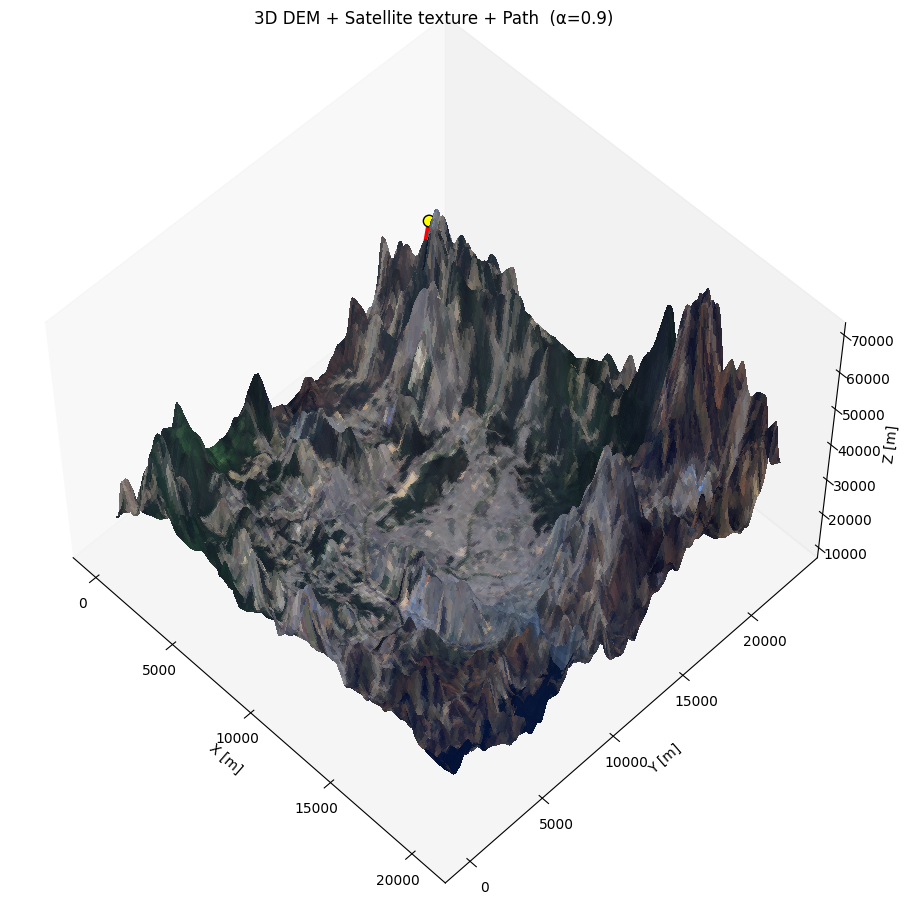

In [25]:
# ==========================================================
# 3) 3D: DEM 표면 + 위성 텍스처(투명도) + 경로 (가시성 보장)
# ==========================================================
from mpl_toolkits.mplot3d import Axes3D  # noqa
from matplotlib import cm

def show_3d_surface_with_sat_texture(res: dict, out: dict, sat_rgb: np.ndarray,
                                     alpha_tex: float = 0.85,
                                     lift_ratio: float = 0.06,
                                     max_grid: int = 600,
                                     title="3D DEM + Satellite texture + Path"):
    from PIL import Image
    import numpy as np
    import matplotlib.pyplot as plt

    Z  = out["Z"]      # (M,N)
    xs = out["xs"]     # (N,)
    ys = out["ys"]     # (M,)
    M, N = Z.shape

    # 텍스처 크기를 DEM 격자에 맞춤
    tex_img = Image.fromarray(sat_rgb).resize((N, M), Image.BILINEAR)
    tex = np.asarray(tex_img).astype(np.float32) / 255.0  # (M,N,3)
    alpha = np.full((M, N, 1), float(alpha_tex), dtype=np.float32)
    facecolors = np.concatenate([tex, alpha], axis=2)

    # 렌더링 다운샘플
    stride = max(1, int(max(M, N) // max_grid))
    Zs  = Z[::stride, ::stride]
    xs_s = xs[::stride]
    ys_s = ys[::stride]
    FCs = facecolors[::stride, ::stride, :]

    X, Y = np.meshgrid(xs_s, ys_s, indexing='xy')

    # 경로 z (최근접) + 띄우기
    path = np.asarray(out["path_xy"], float)
    col_idx = np.clip(np.searchsorted(xs, path[:, 0]), 0, len(xs) - 1)
    row_idx = np.clip(np.searchsorted(ys, path[:, 1]), 0, len(ys) - 1)
    z_line = Z[row_idx, col_idx]
    zmin, zmax = float(np.nanmin(Z)), float(np.nanmax(Z))
    lift = max(1.0, (zmax - zmin) * float(lift_ratio))
    z_line = np.where(np.isfinite(z_line), z_line, zmin) + lift

    # 3D 플롯
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Zs, rstride=1, cstride=1,
                    facecolors=FCs, linewidth=0, antialiased=False, shade=False)
    ax.plot(path[:, 0], path[:, 1], z_line, color='red', lw=3, label="Path")
    ax.scatter([path[0, 0], path[-1, 0]], [path[0, 1], path[-1, 1]],
               [z_line[0], z_line[-1]], s=70, c=['cyan', 'yellow'],
               edgecolors='k', depthshade=False, zorder=10)

    ax.set_title(f"{title}  (α={res['alpha']})")
    ax.set_xlabel("X [m]"); ax.set_ylabel("Y [m]"); ax.set_zlabel("Z [m]")
    ax.view_init(elev=55, azim=-45)
    ax.grid(False)
    plt.tight_layout(); plt.show()

show_3d_surface_with_sat_texture(res, out, sat_rgb, alpha_tex=0.99, lift_ratio=0.08, max_grid=600)


In [14]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, LineString, MultiLineString, Point, MultiPoint
from rasterio.transform import from_origin
from rasterio.features import rasterize
from shapely.affinity import translate

def _ensure_meter_crs(gdf: gpd.GeoDataFrame, target_crs: str | None) -> gpd.GeoDataFrame:
    if target_crs and gdf.crs and gdf.crs != target_crs:
        return gdf.to_crs(target_crs)
    return gdf

def _to_local_coords(gdf: gpd.GeoDataFrame, xmin: float, ymin: float) -> gpd.GeoDataFrame:
    gdf = gdf.copy()
    gdf["geometry"] = gdf.geometry.apply(lambda geom: translate(geom, xoff=-xmin, yoff=-ymin))
    return gdf

def _buffer_for_rasterize(geom, buffer_m: float, dx: float, dy: float):
    """라인/포인트면 buffer_m로 폭을 주고, 폴리곤은 버퍼 0."""
    if geom is None or geom.is_empty:
        return None
    if isinstance(geom, (Polygon, MultiPolygon)):
        return geom if buffer_m <= 0 else geom.buffer(buffer_m)
    if isinstance(geom, (LineString, MultiLineString)):
        return geom.buffer(max(buffer_m, max(dx, dy)*0.5))
    if isinstance(geom, (Point, MultiPoint)):
        return geom.buffer(max(buffer_m, max(dx, dy)*0.5))
    # 그 외는 안전하게 소규모 버퍼
    return geom.buffer(max(buffer_m, max(dx, dy)*0.5))

def build_weight_raster_from_single_shp(
    res: dict,
    out: dict,
    shp_path: str,
    code_col: str = "l3_code",
    code_map: dict | None = None,
    default_weight: float = 1.0,
    default_buffer_m: float = 0.0,
    combine: str = "min",  # {"min","mul","set"}
):
    """
    하나의 SHP에서 code_col(l3_code)로 구분하여 가중치 레스터 W를 생성.

    Parameters
    ----------
    res : build_dem_spectral_model(...) 결과 (crs, bounds_m 등 포함)
    out : build_raster_from_dct(...) 또는 shortest_path_on_f_uniform(...) 결과
          - 필요한 키: "Z"(M,N), "dx","dy","W","H"
    shp_path : 단일 SHP 경로
    code_col : 엔티티 구분 컬럼명 (기본 "l3_code")
    code_map : { code_value: {"weight": float, "buffer_m": float(선택)} }
               예) { "ROAD": {"weight":0.3,"buffer_m":6.0},
                     "RIVER":{"weight":50.0,"buffer_m":8.0},
                     "BLDG":{"weight":1e6} }
               지정되지 않은 code는 default_weight / default_buffer_m 사용
    default_weight : 매핑에 없는 셀 기본 가중치
    default_buffer_m : 매핑에 없는 코드의 기본 버퍼 폭(라인/포인트용)
    combine : 겹침 결합 방식
              - "min": 쉬운 길(작은 weight) 우선
              - "mul": 누적 페널티(곱)
              - "set": 마지막으로 태운 레이어가 덮어씀(우선순위는 처리 순서)

    Returns
    -------
    W : np.ndarray float32 (M,N)
    unique_codes : list  # shp 내 등장한 고유 l3_code 목록(디버깅용)
    """
    Z = out["Z"]; dx, dy = float(out["dx"]), float(out["dy"])
    M, N = Z.shape
    W = np.full((M, N), float(default_weight), dtype=np.float32)

    xmin, xmax, ymin, ymax = res["bounds_m"]
    dem_crs = res["crs"]
    H = out["H"]

    # 래스터 변환(로컬 좌표계: (0,0)~(W,H), 원점은 좌상단)
    transform = from_origin(0.0, H, dx, dy)

    gdf = gpd.read_file(shp_path)
    gdf = _ensure_meter_crs(gdf, dem_crs)
    # DEM 경계의 (xmin,ymin)을 0,0으로 맞춰 동일 로컬 좌표로 이동
    gdf = _to_local_coords(gdf, xmin=xmin, ymin=ymin)

    if code_map is None:
        code_map = {}

    # SHP 안의 고유 코드 확인
    if code_col not in gdf.columns:
        raise KeyError(f"'{code_col}' 컬럼이 SHP에 없습니다.")
    unique_codes = sorted([str(c) for c in gdf[code_col].dropna().unique()])

    # 코드별로 폴리곤화 → 래스터화 → 결합
    for code in unique_codes:
        sub = gdf[gdf[code_col] == code]
        cfg = code_map.get(str(code), {})
        weight = float(cfg.get("weight", default_weight))
        buffer_m = float(cfg.get("buffer_m", default_buffer_m))

        # 지오메트리 버퍼링(라인/포인트는 폭 부여)
        polys = []
        for geom in sub.geometry:
            pg = _buffer_for_rasterize(geom, buffer_m, dx, dy)
            if pg is None or pg.is_empty:
                continue
            # 폴리곤/멀티폴리곤만 남김
            if isinstance(pg, (Polygon, MultiPolygon)):
                polys.append(pg)
            else:
                # 혹시 남은 라인류는 안전 버퍼
                polys.append(pg.buffer(max(buffer_m, max(dx,dy)*0.5)))

        if not polys:
            continue

        arr = rasterize(
            shapes=[(p, weight) for p in polys],
            out_shape=(M, N),
            transform=transform,
            fill=0.0,
            dtype="float32",
            all_touched=True
        )

        if combine == "min":
            # arr>0인 곳만 유효, 그 값과 현재 W의 min
            W = np.minimum(W, np.where(arr > 0, arr, np.inf)).astype(np.float32)
            W[np.isinf(W)] = W[np.isinf(W)] = default_weight
        elif combine == "mul":
            W = (W * np.where(arr > 0, arr, 1.0)).astype(np.float32)
        elif combine == "set":
            mask = arr > 0
            W[mask] = arr[mask].astype(np.float32)
        else:
            raise ValueError("combine must be one of {'min','mul','set'}")

    return W, unique_codes


In [15]:
import heapq
import math
import numpy as np

def shortest_path_weighted(
    out: dict,
    W: np.ndarray,
    start_xy: tuple[float,float],
    goal_xy: tuple[float,float],
    connectivity: int = 8,
):
    """
    out: 그리드 메타 (Z, xs, ys, dx, dy, W, H)
    W  : 가중치 레스터 (M,N). 값이 클수록 통과 비용↑ (1e6~inf은 사실상 벽)
    이동 비용 = 이동거리 * W(도착셀)
    """
    Z = out["Z"]; dx, dy = float(out["dx"]), float(out["dy"])
    M, N = Z.shape

    def xy_to_rc(x, y):
        c = int(round(x / dx))
        r = int(round(y / dy))
        return max(0, min(M-1, r)), max(0, min(N-1, c))
    def rc_to_xy(r, c):
        return (c*dx, r*dy)

    s = xy_to_rc(*start_xy)
    g = xy_to_rc(*goal_xy)

    if not np.isfinite(W[s]) or W[s] >= 1e12: raise ValueError("시작 셀이 통과 불가")
    if not np.isfinite(W[g]) or W[g] >= 1e12: raise ValueError("목표 셀이 통과 불가")

    if connectivity == 4:
        nbrs = [(1,0,dx),( -1,0,dx),(0,1,dy),(0,-1,dy)]
    else:
        diag = math.hypot(dx,dy)
        nbrs = [(1,0,dx),(-1,0,dx),(0,1,dy),(0,-1,dy),
                (1,1,diag),(1,-1,diag),(-1,1,diag),(-1,-1,diag)]

    def heuristic(a, b):
        # 옥타일(8방향) 휴리스틱(일관성/허용성 만족)
        (r1,c1),(r2,c2)=a,b
        D  = min(dx,dy); D2 = max(dx,dy)
        dr, dc = abs(r1-r2), abs(c1-c2)
        return (D2-D)*min(dr,dc) + D*(max(dr,dc)-min(dr,dc))

    openh = []
    gscore = {s: 0.0}
    heapq.heappush(openh, (heuristic(s,g), 0.0, s))
    came = {s: None}
    closed = set()

    while openh:
        f, gc, cur = heapq.heappop(openh)
        if cur in closed: continue
        if cur == g: break
        closed.add(cur)

        r,c = cur
        for dr,dc,dist in nbrs:
            nr, nc = r+dr, c+dc
            if nr<0 or nr>=M or nc<0 or nc>=N: continue
            w = W[nr, nc]
            if not np.isfinite(w) or w >= 1e12:  # 벽 취급
                continue
            tg = gc + dist * float(w)
            if tg < gscore.get((nr,nc), 1e30):
                gscore[(nr,nc)] = tg
                came[(nr,nc)] = cur
                heapq.heappush(openh, (tg + heuristic((nr,nc), g), tg, (nr,nc)))

    if g not in came:
        raise RuntimeError("경로를 찾지 못했습니다.")

    # 경로 복구
    path_rc = []
    cur = g
    while cur is not None:
        path_rc.append(cur)
        cur = came[cur]
    path_rc.reverse()
    path_xy = [ (c*dx, r*dy) for r,c in path_rc ]
    total_cost = gscore[g]
    return {"path_xy": path_xy, "total_cost": float(total_cost)}


In [16]:
import math
import numpy as np
from PIL import Image
import plotly.graph_objects as go
from scipy.interpolate import RegularGridInterpolator

def plotly_3d_dem_textured(
    res: dict,
    out: dict,
    sat_rgb: np.ndarray,
    grid_max: int = 700,             # DEM을 이 해상도 이하로 다운샘플 (성능/메모리)
    path_lift_ratio: float = 0.06,   # 경로를 표면 위로 살짝 띄우기
    mesh_opacity: float = 1.0,       # 표면 전체 투명도 (vertexcolor엔 per-pixel alpha 없음)
    camera_eye = dict(x=2.0, y=1.8, z=0.6),
    aspect_ratio = dict(x=1, y=1, z=0.22),
    save_html: str | None = None
):
    """
    res, out: 네가 쓰던 그대로 (out['Z'], out['xs'], out['ys'], out['path_xy'] 포함)
    sat_rgb: z/x/y 타일 모자이크 결과 (H,W,3) uint8
    """
    Z  = out["Z"]; xs = out["xs"]; ys = out["ys"]
    path = np.asarray(out["path_xy"], float)
    M, N = Z.shape

    # 1) 다운샘플(균형 유지)
    stride = max(1, math.ceil(max(M, N) / grid_max))
    Zs  = Z[::stride, ::stride]
    xs_s = xs[::stride]
    ys_s = ys[::stride]
    Ms, Ns = Zs.shape
    Xs, Ys = np.meshgrid(xs_s, ys_s, indexing="xy")

    # 2) 위성 텍스처를 DEM 그리드 크기에 맞춰 리사이즈 → vertexcolor
    tex = Image.fromarray(sat_rgb).resize((Ns, Ms), Image.BILINEAR)
    tex = np.asarray(tex, dtype=np.uint8)    # (Ms, Ns, 3)

    # 3) 그리드를 Mesh3d로 삼각분할 (두 삼각형/셀)
    vidx = np.arange(Ms * Ns, dtype=np.int32).reshape(Ms, Ns)

    # 왼쪽 아래 삼각형 (i, j) -> (i, j+1) -> (i+1, j)
    i1 = vidx[:-1, :-1].ravel()
    j1 = vidx[:-1, 1: ].ravel()
    k1 = vidx[1: , :-1].ravel()

    # 오른쪽 위 삼각형 (i+1, j+1) -> (i+1, j) -> (i, j+1)
    i2 = vidx[1: , 1: ].ravel()
    j2 = vidx[1: , :-1].ravel()
    k2 = vidx[:-1, 1: ].ravel()

    I = np.concatenate([i1, i2])
    J = np.concatenate([j1, j2])
    K = np.concatenate([k1, k2])

    # 4) 정점 좌표/색
    verts_x = Xs.ravel()
    verts_y = Ys.ravel()
    verts_z = Zs.ravel()

    # vertexcolor는 (n,3) 또는 (n,4) 형태의 RGB(A)
    vcol = tex.reshape(-1, 3)  # (Ms*Ns, 3) uint8

    # Light position must be within [-100000, 100000]
    def _clamp_light(v: float) -> float:
        return max(-100000.0, min(100000.0, float(v)))
    # Use scene extent as a guide
    extent_xy = max(float(xs[-1] - xs[0]), float(ys[-1] - ys[0]))
    L = _clamp_light(max(1000.0, extent_xy * 0.5))

    mesh = go.Mesh3d(
        x=verts_x, y=verts_y, z=verts_z,
        i=I, j=J, k=K,
        vertexcolor=vcol,      # 위성 RGB가 고도에 드레이프됨
        opacity=float(mesh_opacity),
        flatshading=False,
        name="Textured DEM",
        lighting=dict(ambient=0.6, diffuse=0.8, specular=0.1, roughness=0.8),
        lightposition=dict(x=L, y=L, z=L),
        showscale=False
    )

    # 5) 경로 z: 표면에서 보간 + lift
    interp = RegularGridInterpolator((ys, xs), Z, bounds_error=False, fill_value=np.nan, method="linear")
    z_on_surface = interp(np.c_[path[:,1], path[:,0]])
    # NaN 보정
    z_on_surface = np.where(np.isnan(z_on_surface), np.nanmin(Z), z_on_surface)
    zmin, zmax = float(np.nanmin(Zs)), float(np.nanmax(Zs))
    lift = max(1.0, (zmax - zmin) * float(path_lift_ratio))
    z_path = z_on_surface + lift

    path3d = go.Scatter3d(
        x=path[:,0], y=path[:,1], z=z_path,
        mode="lines+markers",
        line=dict(width=6, color="red"),
        marker=dict(size=4, color="black"),
        name="Path"
    )

    layout = go.Layout(
        title=f"Textured DEM + Path (α={res['alpha']})",
        scene=dict(
            aspectmode="manual",
            aspectratio=aspect_ratio,
            xaxis_title="X [m]",
            yaxis_title="Y [m]",
            zaxis_title="Z [m]"
        ),
        width=1200, height=850,
        scene_camera=dict(eye=camera_eye),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig = go.Figure(data=[mesh, path3d], layout=layout)
    if save_html:
        from plotly.offline import plot as plot_offline
        plot_offline(fig, filename=save_html, auto_open=False)
        print(f"[OK] saved: {save_html}")
    fig.show()


In [17]:
# ========================================
# SHP -> Weight raster (debug prints + fixes)
# ========================================
from typing import Dict, Any, Tuple

def build_weight_raster_from_single_shp(
    res: dict,
    out: dict,
    shp_path: str,
    code_col: str = "l3_code",
    code_map: Dict[Any, Dict[str, Any]] | None = None,
    default_weight: float = 1.0,
    default_buffer_m: float = 0.0,
    combine: str = "min",  # {"min","mul","set"}
    debug: bool = True,
) -> Tuple[np.ndarray, list]:
    """
    하나의 SHP에서 code_col 값별로 가중치 레스터 W를 생성.
    - 좌표체계/정렬 문제를 제거하기 위해, 지오메트리는 DEM CRS로 맞추고
      transform=from_origin(xmin, ymax, dx, dy) 로 바로 rasterize합니다(별도의 translate 불필요).
    - 라인/포인트는 buffer_m<=0일 때 픽셀 절반 폭으로 최소 버퍼를 자동 부여.
    - combine='min' 로직 수정: 해당 셀만 갱신.
    - 풍부한 디버그 출력 추가.
    """
    import geopandas as gpd
    from shapely.geometry import (Polygon, MultiPolygon, LineString, MultiLineString, Point, MultiPoint)
    from shapely.geometry.base import BaseGeometry
    from shapely.affinity import scale
    from rasterio.transform import from_origin
    from rasterio.features import rasterize

    # --- 메타 ---
    Z = out["Z"]; dx, dy = float(out["dx"]), float(out["dy"])
    M, N = Z.shape
    xmin, xmax, ymin, ymax = res["bounds_m"]
    dem_crs = res.get("crs")

    if debug:
        print("[W] DEM grid:", (M, N), "dx,dy=", dx, dy)
        print("[W] DEM bounds_m:", (xmin, xmax, ymin, ymax))
        print("[W] DEM CRS:", dem_crs)

    # --- 변환자: DEM CRS 좌표계를 Transform으로 사용 ---
    transform = from_origin(float(xmin), float(ymax), dx, dy)
    if debug:
        print("[W] Rasterize transform(from_origin):", transform)

    # --- SHP 읽기 & CRS 정합 ---
    gdf = gpd.read_file(shp_path)
    if debug:
        print("[W] SHP read:", shp_path, "rows=", len(gdf))
        print("[W] SHP CRS:", gdf.crs)

    if dem_crs and gdf.crs and gdf.crs != dem_crs:
        if debug:
            print(f"[W] Reproject SHP -> DEM CRS ({dem_crs})")
        gdf = gdf.to_crs(dem_crs)

    if code_col not in gdf.columns:
        raise KeyError(f"'{code_col}' 컬럼이 SHP에 없습니다. cols={list(gdf.columns)[:10]}...")

    # 코드 타입 표준화: 문자열 기반으로 처리
    gdf["__code_str__"] = gdf[code_col].astype(str)
    unique_codes = sorted(gdf["__code_str__"].dropna().unique().tolist())

    # 매핑 키도 문자열로 표준화
    code_map = code_map or {}
    code_map_str = {str(k): v for k, v in code_map.items()}

    if debug:
        print("[W] Unique codes in SHP:", unique_codes[:20], ("..." if len(unique_codes) > 20 else ""))
        missing_cfg = [c for c in unique_codes if c not in code_map_str]
        print(f"[W] Codes without mapping: {len(missing_cfg)}")
        if missing_cfg[:10]:
            print("    sample:", missing_cfg[:10])

    # --- 결과 레스터 초기화 ---
    W = np.full((M, N), float(default_weight), dtype=np.float32)

    # --- 유틸: 버퍼/폴리곤화 ---
    def buffered_polygons(geom: BaseGeometry, buf_m: float) -> list:
        if geom is None or geom.is_empty:
            return []
        # 폴리곤류
        if isinstance(geom, (Polygon, MultiPolygon)):
            if buf_m and buf_m > 0:
                g2 = geom.buffer(float(buf_m))
                return [g2] if isinstance(g2, Polygon) else list(g2.geoms)
            return [geom] if isinstance(geom, Polygon) else list(geom.geoms)
        # 라인/포인트류
        min_half_pixel = max(dx, dy) * 0.5
        eff = float(buf_m) if (buf_m and buf_m > 0) else min_half_pixel
        g2 = geom.buffer(eff)
        if g2 is None or g2.is_empty:
            return []
        return [g2] if isinstance(g2, Polygon) else list(g2.geoms)

    # --- 코드별 처리 ---
    total_covered = 0
    for code in unique_codes:
        sub = gdf[gdf["__code_str__"] == code]
        cfg = code_map_str.get(code, {})
        weight = float(cfg.get("weight", default_weight))
        buffer_m = float(cfg.get("buffer_m", default_buffer_m))

        if debug:
            print(f"[W][{code}] features= {len(sub)} weight= {weight} buffer_m= {buffer_m}")

        shapes = []
        c_feat = 0
        for geom in sub.geometry:
            polys = buffered_polygons(geom, buffer_m)
            for p in polys:
                if p is not None and not p.is_empty:
                    shapes.append((p, weight))
            c_feat += 1
        if not shapes:
            if debug:
                print(f"    -> no polygons after buffering; skip")
            continue

        arr = rasterize(
            shapes=shapes,
            out_shape=(M, N),
            transform=transform,
            fill=0.0,
            dtype="float32",
            all_touched=True,
        )
        covered = int((arr > 0).sum())
        total_covered += covered

        if debug:
            if covered:
                arr_mask = arr[arr > 0]
                print(f"    -> rasterized cells: {covered}, arr(min,max)=({arr_mask.min():.3g},{arr_mask.max():.3g})")
            else:
                print("    -> rasterized cells: 0 (check CRS/buffer/bounds)")

        # 결합
        if combine == "min":
            mask = arr > 0
            W[mask] = np.minimum(W[mask], arr[mask]).astype(np.float32)
        elif combine == "mul":
            W = (W * np.where(arr > 0, arr, 1.0)).astype(np.float32)
        elif combine == "set":
            mask = arr > 0
            W[mask] = arr[mask].astype(np.float32)
        else:
            raise ValueError("combine must be one of {'min','mul','set'}")

    if debug:
        changed = int(np.sum(W != float(default_weight)))
        print(f"[W] total covered cells: {total_covered}")
        print(f"[W] W stats: min={float(np.nanmin(W)):.3g} max={float(np.nanmax(W)):.3g} changed={changed}/{W.size}")

    return W, unique_codes

In [24]:
# 1) (이미 있음) DCT 근사 그리드 out
# out = build_raster_from_dct(res, dx=90.0, dy=90.0)

code_map = {
    # ====== 주거 및 건축물류 (거의 불가) ======
    111: {"weight": 100.0},   # 단독주거시설
    112: {"weight": 100.0},   # 공동주거시설
    121: {"weight": 80.0},    # 공업시설
    131: {"weight": 80.0},    # 상업·업무시설
    132: {"weight": 70.0},    # 혼합지역
    141: {"weight": 30.0},    # 문화·체육·휴양시설
    151: {"weight": 1e6},     # 공항 (통행 불가)
    152: {"weight": 1e6},     # 항만 (통행 불가)
    153: {"weight": 500.0},   # 철도 (사실상 불가)
    154: {"weight": 0.3, "buffer_m": 6.0},  # 도로 (통행 가능, 우선)
    155: {"weight": 0.6},     # 기타 교통·통신시설
    161: {"weight": 1.0},     # 환경기초시설
    162: {"weight": 2.0},     # 교육·행정시설
    163: {"weight": 2.0},     # 기타 공공시설

    # ====== 농경지 / 식생 (보통 가능) ======
    211: {"weight": 1.5},  # 정리된 논
    212: {"weight": 2.0},  # 정리 안 된 논
    221: {"weight": 1.5},  # 정리된 밭
    222: {"weight": 2.0},  # 정리 안 된 밭
    231: {"weight": 3.0},  # 시설재배지
    241: {"weight": 3.0},  # 과수원
    251: {"weight": 4.0},  # 목장·양식장
    252: {"weight": 5.0},  # 기타 재배지

    # ====== 산림·초지 (부분 가능) ======
    311: {"weight": 8.0},   # 활엽수림
    321: {"weight": 10.0},  # 침엽수림
    331: {"weight": 9.0},   # 혼효림
    411: {"weight": 6.0},   # 자연초지
    421: {"weight": 2.0},   # 골프장 (통행 가능)
    422: {"weight": 4.0},   # 묘지
    423: {"weight": 5.0},   # 기타초지

    # ====== 수변·습지 (거의 불가) ======
    511: {"weight": 1e6},  # 내륙습지
    521: {"weight": 1e6},  # 갯벌
    522: {"weight": 1e6},  # 염전

    # ====== 해안 및 수체계 (불가) ======
    611: {"weight": 1e6},  # 해변
    612: {"weight": 1e6},  # 강기슭
    613: {"weight": 1e6},  # 암벽·바위
    621: {"weight": 1e6},  # 채광지역
    622: {"weight": 1e6},  # 운동장 (넓은 콘크리트 지역)
    623: {"weight": 5.0},  # 기타 나지 (부분 가능)
    711: {"weight": 1e6},  # 하천
    712: {"weight": 1e6},  # 호소
    721: {"weight": 1e6},  # 해양수
}


W, codes = build_weight_raster_from_single_shp(
    res, out,
    shp_path=r"C:\Users\inho9\Desktop\dev\GISProject\DATA\Daejeon.shp",
    code_col="l3_code",
    code_map=code_map,
    default_weight=1.0,
    default_buffer_m=0.0,
    combine="min"   # 쉬운길 우선
)
print("unique l3_code:", codes)

# 3) 가중 A*로 경로
res_w = shortest_path_weighted(
    out, W,
    start_xy=(0.60*out["W"], 0.10*out["H"]),
    goal_xy=(0.6*out["W"], 0.85*out["H"]),
    connectivity=8
)
print("weighted total cost:", res_w["total_cost"])

# 4) 3D 렌더(텍스처드 + 새 경로)
out_w = out.copy()
out_w["path_xy"] = res_w["path_xy"]
plotly_3d_dem_textured(
    res, out_w, sat_rgb,
    grid_max=700, path_lift_ratio=0.06,
    aspect_ratio=dict(x=1,y=1,z=0.22),
    camera_eye=dict(x=2.2,y=1.8,z=0.65),
    save_html="dem_textured_weighted_l3.html"
)


[W] DEM grid: (259, 229) dx,dy= 90.0 90.0
[W] DEM bounds_m: (14169367.2908, 14192774.2894, 4337875.3787, 4358528.6128)
[W] DEM CRS: EPSG:3857
[W] Rasterize transform(from_origin): | 90.00, 0.00, 14169367.29|
| 0.00,-90.00, 4358528.61|
| 0.00, 0.00, 1.00|
[W] SHP read: C:\Users\inho9\Desktop\dev\GISProject\DATA\Daejeon.shp rows= 292904
[W] SHP CRS: EPSG:3857
[W] Unique codes in SHP: ['111', '112', '121', '131', '141', '153', '154', '155', '161', '162', '163', '212', '222', '231', '241', '251', '252', '311', '321', '331'] ...
[W] Codes without mapping: 0
[W][111] features= 68182 weight= 100.0 buffer_m= 0.0
    -> rasterized cells: 9423, arr(min,max)=(100,100)
[W][112] features= 23101 weight= 100.0 buffer_m= 0.0
    -> rasterized cells: 10211, arr(min,max)=(100,100)
[W][121] features= 5225 weight= 80.0 buffer_m= 0.0
    -> rasterized cells: 1460, arr(min,max)=(80,80)
[W][131] features= 79222 weight= 80.0 buffer_m= 0.0
    -> rasterized cells: 19194, arr(min,max)=(80,80)
[W][141] features=

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed